In [1]:
import pandas as pd
import numpy as np
import requests
import re

In [2]:
# urls to the API
urlMales = 'https://c3po.crossfit.com/api/competitions/v2/competitions/games/2022/leaderboards?division=1&sort=0&page=1'

# Sends the request and reads the response.
responseMales = requests.get(urlMales)

# Loads response as JSON
responseMales = responseMales.json()

In [3]:
# select a competitor to see what data we have
leaderboardRows = responseMales['leaderboardRows']
responseMales['leaderboardRows'][20].keys()

dict_keys(['overallRank', 'overallScore', 'nextStage', 'ui', 'entrant', 'scores'])

In [4]:
# how many competitors, used for for loops
totalMaleCompetitors = responseMales['pagination'] ['totalCompetitors']

# how many events, used for for loops
totalEvents = len(responseMales['ordinals'])

In [5]:
# create functions to standartize height and weight of the athlets

def inches_to_cm(height):
    if "in" in height: # if height in inches
        inches = float(height.split(" ")[0])  # extract the numeric value
        cm = inches * 2.54  # convert inches to centimeters
        return int(f"{cm:.0f}")  # format the result with 2 decimal places and 'cm' unit
    else:
        cm = float(height.split(" ")[0]) # Height in cm, extract the numeric value 
        return int(f"{cm:.0f}")
    
def lb_to_kg(weight):
    if "lb" in weight: # if weight in lbs
        lb = float(weight.split(" ")[0])  # extract the numeric value
        kg = lb * 0.4536  # convert lbs to kg
        return int(f"{kg:.0f}")  # cormat the result with 2 decimal places without unit
    else:
        kg = float(weight.split(" ")[0])  # weight in kg, extract the numeric value
        return int(f"{kg:.0f}")

In [6]:
# create a dataframe that contains one line for every male competitor
df_cfgMales = pd.DataFrame(np.zeros((totalMaleCompetitors, 9)),columns=['competitorId','competitorName','overallRank', 'overallScore', 'heightInCm', 'weightInKg', 'age', 'countryOfOriginName','affiliateName'])
# just filling the dataframe with nan data
df_cfgMales = df_cfgMales.replace(0,np.nan)
# loop over all events for all competitors
for i in range(0,totalMaleCompetitors,1):
    competitorData = responseMales['leaderboardRows'][i]
        
    # competition data
    df_cfgMales.loc[i,'overallRank'] = competitorData['overallRank']

    if len(competitorData['overallScore']) < 1:
        df_cfgMales.loc[i,'overallScore'] = "0"
    else:
        df_cfgMales.loc[i,'overallScore'] = competitorData['overallScore']      
    # get some personal data
    df_cfgMales.loc[i,'competitorId'] = str(competitorData['entrant']['competitorId'])
    df_cfgMales.loc[i,'competitorName'] = competitorData['entrant']['competitorName']
    df_cfgMales.loc[i,'countryOfOriginName'] = competitorData['entrant']['countryOfOriginName']
    df_cfgMales.loc[i,'heightInCm'] = inches_to_cm(competitorData['entrant']['height'])
    df_cfgMales.loc[i,'age'] = competitorData['entrant']['age']
    df_cfgMales.loc[i,'weightInKg'] = lb_to_kg(competitorData['entrant']['weight'])
    try:
        df_cfgMales.loc[i,'affiliateName'] = competitorData['entrant']['affiliateName']
    except:
        df_cfgMales.loc[i,'affiliateName'] = 'Unaffiliated'
    # clean the "T" from workoutRank, this is when athletes are tied in a workout
    try:
        df_cfgMales.loc[i,'overallRank'] = re.sub("\D", "", df_cfgMales.loc[i,'overallRank'])
    except:
        df_cfgMales.loc[i,'overallRank'] = df_cfgMales['overallRank']
    df_cfgMales.loc[i,'overallRank'] = int(df_cfgMales.loc[i,'overallRank'])

# change overallRank and overallScore to a numeric value so we can to some calculations
df_cfgMales['overallRank'] = df_cfgMales['overallRank'].astype('int')
df_cfgMales['overallScore'] = df_cfgMales['overallScore'].astype('int')
df_cfgMales['age'] = df_cfgMales['age'].astype('int') 
df_cfgMales['weightInKg'] = df_cfgMales['weightInKg'].astype('int')
df_cfgMales['heightInCm'] = df_cfgMales['heightInCm'].astype('int')

# update country of 2 athlets because it's empty
df_cfgMales.loc[[1, 38], ['countryOfOriginName']] = ['Russia']

In [7]:
df_cfgMales.head()

,competitorId,competitorName,overallRank,overallScore,heightInCm,weightInKg,age,countryOfOriginName,affiliateName
0,811708,Justin Medeiros,1,1184,175,88,23,United States,CrossFit Fort Vancouver
1,975774,Roman Khrennikov,2,1157,182,103,27,Russia,
2,40955,Ricky Garard,3,1068,179,91,28,Australia,
3,74320,Samuel Kwant,4,975,180,93,26,United States,
4,469656,Jeffrey Adler,5,950,175,89,28,Canada,CrossFit Wonderland


In [8]:
numberOfLinesMales = totalMaleCompetitors * totalEvents # total lines for 14 events 40 athlets

# create a dataframe that contains one line for every event for every competitor
df_cfgMalesEvents = pd.DataFrame(np.zeros((numberOfLinesMales,4)),columns=['competitorId', 'event', 'points', 'workoutRank'])
# filling the dataframe with nan data
df_cfgMalesEvents = df_cfgMalesEvents.replace(0,np.nan)

# loop over competitors
for i in range(0,totalMaleCompetitors,1):
    competitorData = responseMales['leaderboardRows'][i]
    # loop over all events for athlete i
    for j in range(0,totalEvents):
        df_cfgMalesEvents.loc[j+(i*totalEvents),'competitorId'] = str(competitorData['entrant']['competitorId'])
        # event results
        df_cfgMalesEvents.loc[j+(i*totalEvents),'event'] = competitorData['scores'][j]['ordinal']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'points'] = competitorData['scores'][j]['score']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = competitorData['scores'][j]['rank']
        # clean the "T" from workoutRank, this is when athletes are tied in a workout
        try:
            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = re.sub("\D", "", 
                                                                            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'])
        except:
            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank']

# change non-numeric columns to numeric so we can to some calculations on them
df_cfgMalesEvents['points'] = df_cfgMalesEvents['points'].astype('int')
df_cfgMalesEvents['event'] = df_cfgMalesEvents['event'].astype('int')
df_cfgMalesEvents['workoutRank'] = df_cfgMalesEvents['workoutRank'].astype('int')

In [9]:
df_cfgMalesEvents.describe()

,event,points,workoutRank
count,560.000000,560.000000,560.000000
mean,7.500000,43.896429,20.217857
std,4.034733,30.387067,11.236236
min,1.000000,0.000000,1.000000
25%,4.000000,18.000000,10.750000
50%,7.500000,40.000000,20.500000
75%,11.000000,70.000000,30.000000
max,14.000000,100.000000,40.000000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

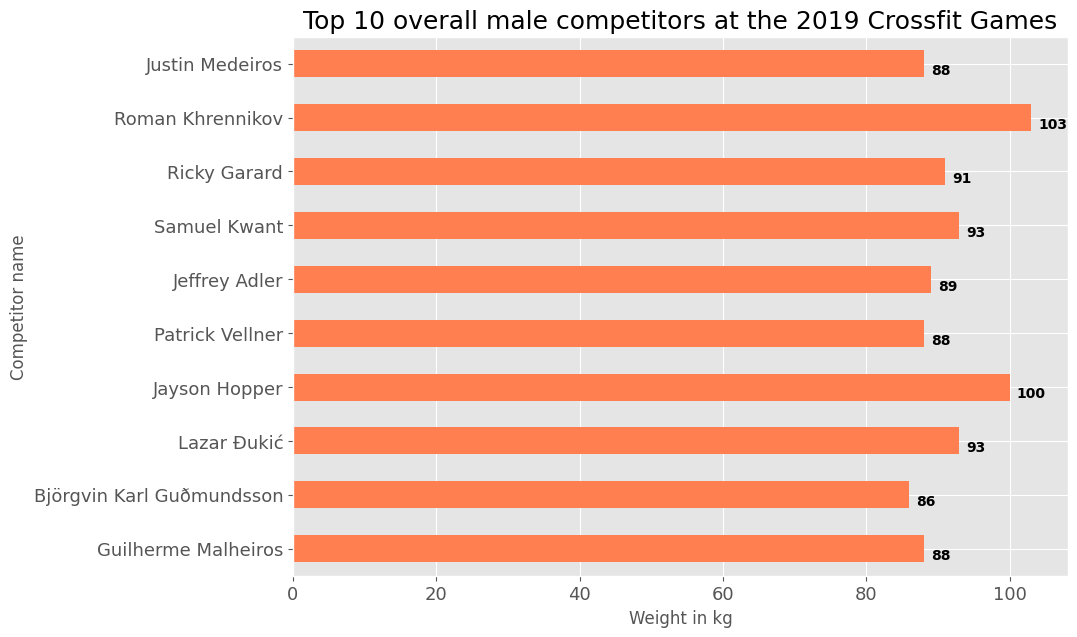

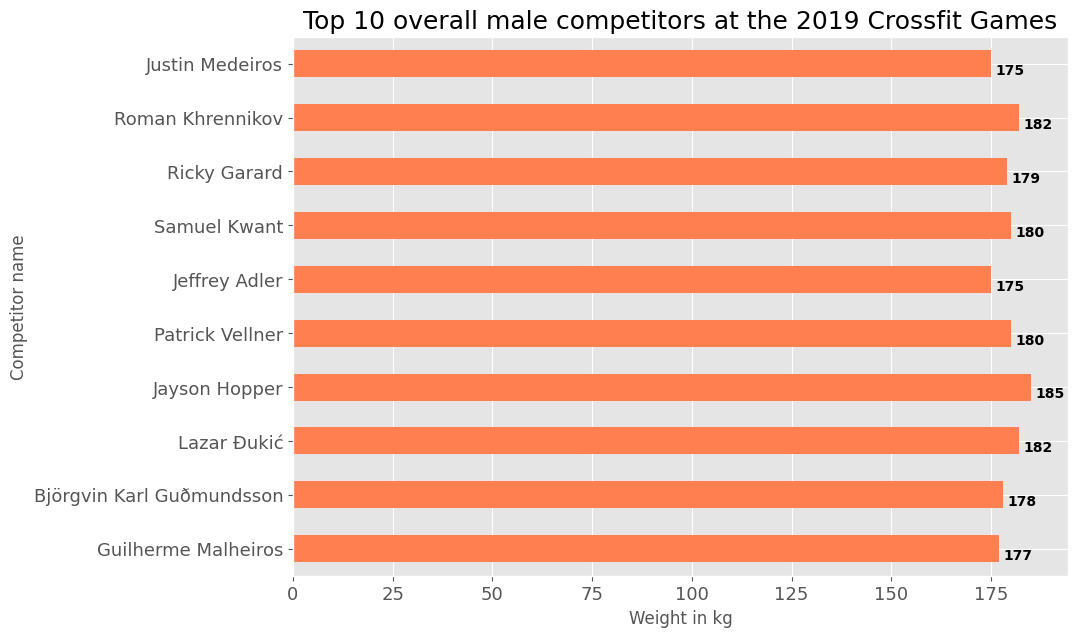

In [11]:
top10weightMales = df_cfgMales[(['competitorName','weightInKg','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10weightMales.plot(kind='barh', x='competitorName', y='weightInKg',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top10weightMales
                      ['weightInKg']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
# plt.savefig('top10weightMales.png', bbox_inches='tight')
plt.show()

top10heightMales = df_cfgMales[(['competitorName','heightInCm','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10heightMales.plot(kind='barh', x='competitorName', y='heightInCm',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top10heightMales
                      ['heightInCm']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
# plt.savefig('top10weightMales.png', bbox_inches='tight')
plt.show()

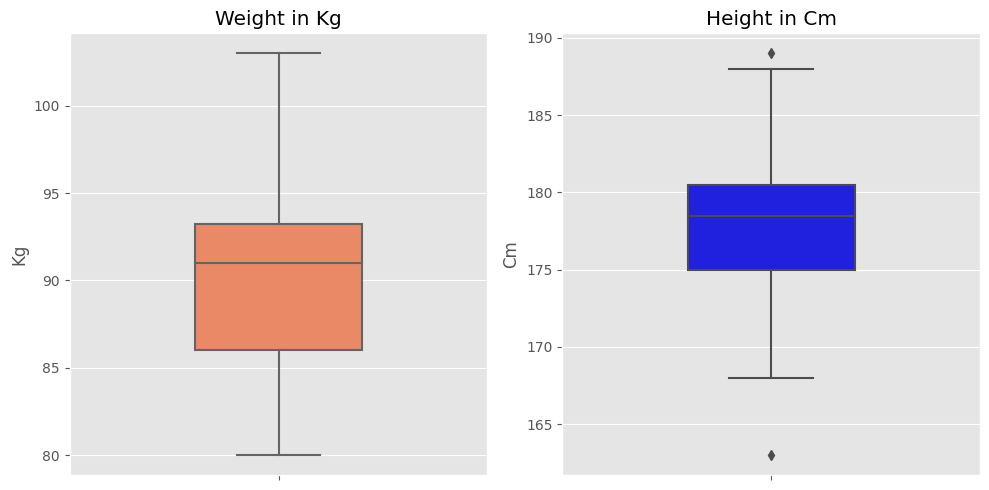

In [12]:
# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first boxplot for "weightInKg" on the first subplot (ax1)
sns.boxplot(data=df_cfgMales, color="coral", width=0.4, y="weightInKg", ax=ax1)
ax1.set_title("Weight in Kg")

# Plot the second boxplot for "heightInCm" on the second subplot (ax2)
sns.boxplot(data=df_cfgMales, color="blue", width=0.4, y="heightInCm", ax=ax2)
ax2.set_title("Height in Cm")

# Set labels for the y axes
ax1.set_ylabel("Kg")
ax2.set_ylabel("Cm")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

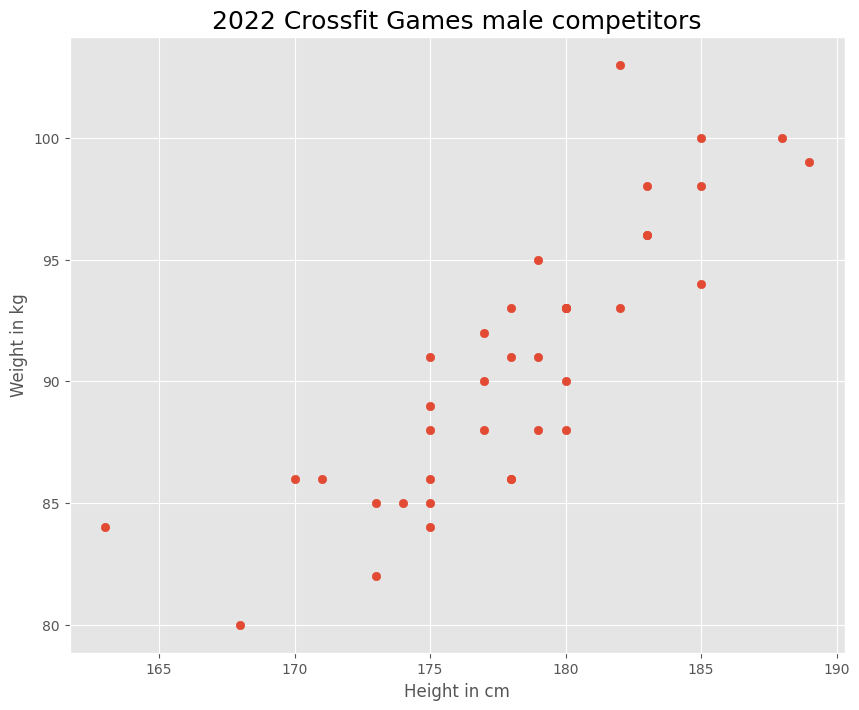

In [13]:
plt.figure(figsize=(10,8))
plt.style.use('ggplot')
plt.scatter(df_cfgMales['heightInCm'] ,df_cfgMales['weightInKg'])
plt.title('2022 Crossfit Games male competitors', fontsize=18)
plt.ylabel('Weight in kg')
plt.xlabel('Height in cm')
plt.show()

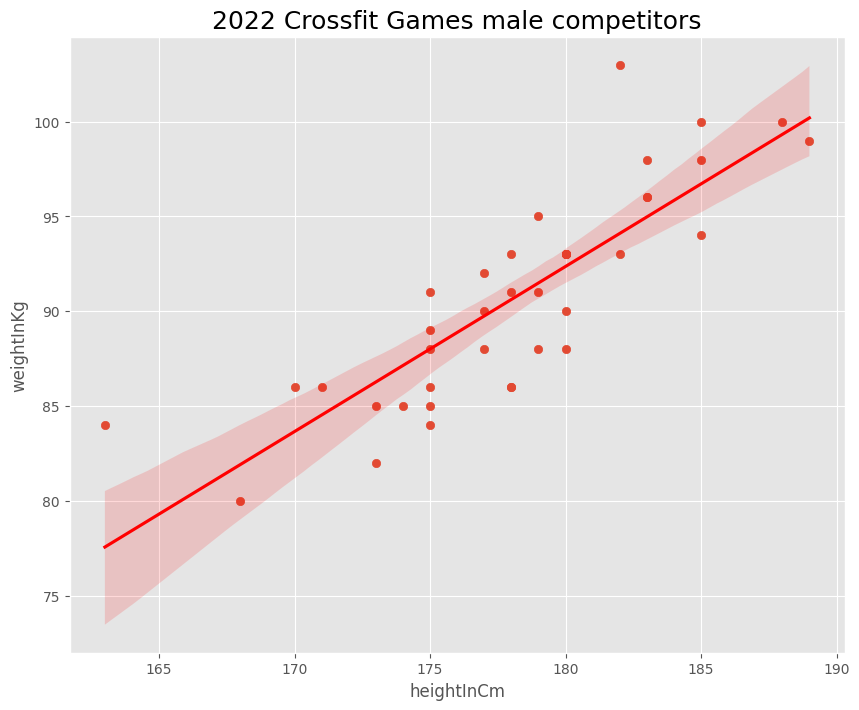

In [14]:
plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
plt.scatter(df_cfgMales['heightInCm'], df_cfgMales['weightInKg'])
plt.title('2022 Crossfit Games male competitors', fontsize=18)
plt.ylabel('Weight in kg')
plt.xlabel('Height in cm')

# Add the regression line using seaborn
sns.regplot(x=df_cfgMales['heightInCm'], y=df_cfgMales['weightInKg'], scatter=False, color='red')

# Save the plot as an image
# plt.savefig('heightAndweightMales.png')

# Display the plot
plt.show()

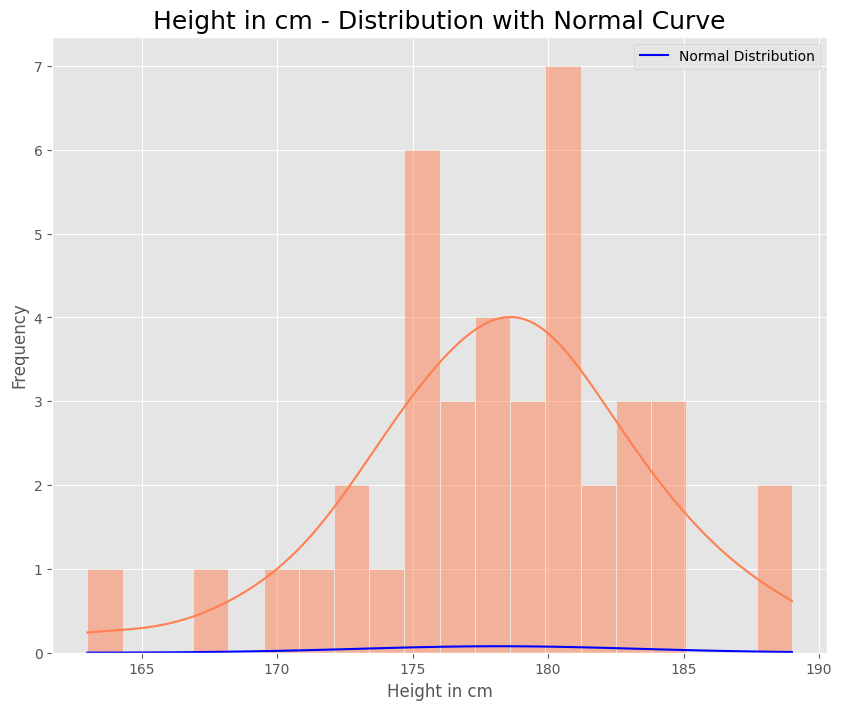

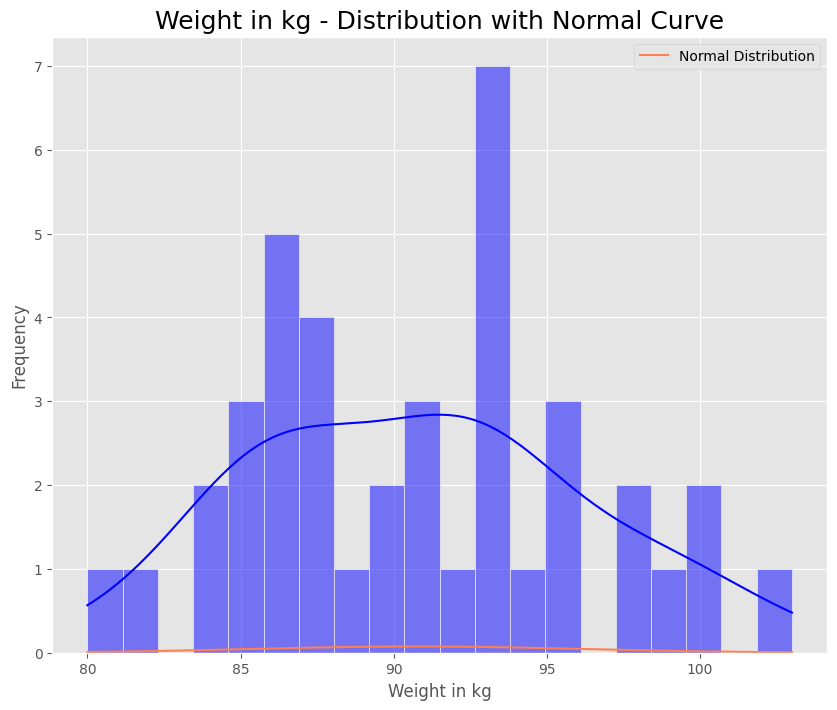

In [15]:
plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
sns.histplot(df_cfgMales['heightInCm'], kde=True, color='coral', bins=20)
plt.title('Height in cm - Distribution with Normal Curve', fontsize=18)
plt.xlabel('Height in cm')
plt.ylabel('Frequency')

# Fit a normal distribution to the 'heightInCm' data
height_mean, height_std = norm.fit(df_cfgMales['heightInCm'])
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(df_cfgMales['heightInCm'].min(), df_cfgMales['heightInCm'].max(), 100)
# Calculate the corresponding y-values for the normal distribution curve
y = norm.pdf(x, height_mean, height_std)
# Plot the normal distribution curve
plt.plot(x, y, color='blue', label='Normal Distribution')

plt.legend()
# plt.savefig('heightDistributionWithNormal.png')
plt.show()

# Plot histogram for "weightInKg" with normal distribution curve
plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
sns.histplot(df_cfgMales['weightInKg'], kde=True, color='blue', bins=20)
plt.title('Weight in kg - Distribution with Normal Curve', fontsize=18)
plt.xlabel('Weight in kg')
plt.ylabel('Frequency')

# Fit a normal distribution to the 'weightInKg' data
weight_mean, weight_std = norm.fit(df_cfgMales['weightInKg'])
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(df_cfgMales['weightInKg'].min(), df_cfgMales['weightInKg'].max(), 100)
# Calculate the corresponding y-values for the normal distribution curve
y = norm.pdf(x, weight_mean, weight_std)
# Plot the normal distribution curve
plt.plot(x, y, color='coral', label='Normal Distribution')

plt.legend()
# plt.savefig('weightDistributionWithNormal.png')
plt.show()

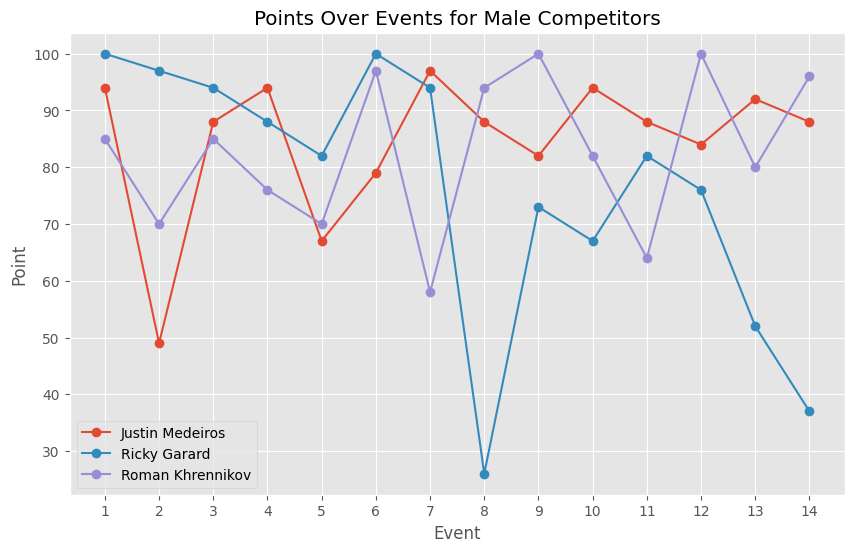

In [18]:
# cheking 3 top athlets during the events
merged_df = pd.merge(df_cfgMalesEvents, df_cfgMales.head(3)[['competitorId', 'competitorName']], on='competitorId')

plt.figure(figsize=(10, 6))
for name, group in merged_df.groupby('competitorName'):
    plt.plot(group['event'], group['points'], label=name, marker='o')

plt.title('Points Over Events for Male Competitors')
plt.xlabel('Event')
plt.ylabel('Point')
plt.legend()
plt.grid(True)
plt.xticks(merged_df['event'].unique())
plt.show()

We can see that Garard started pretty hight but event 8 was the lowest result of all three athlets and after that event Garard couldn't take back his game. We can look closer at Roman and Justin results.

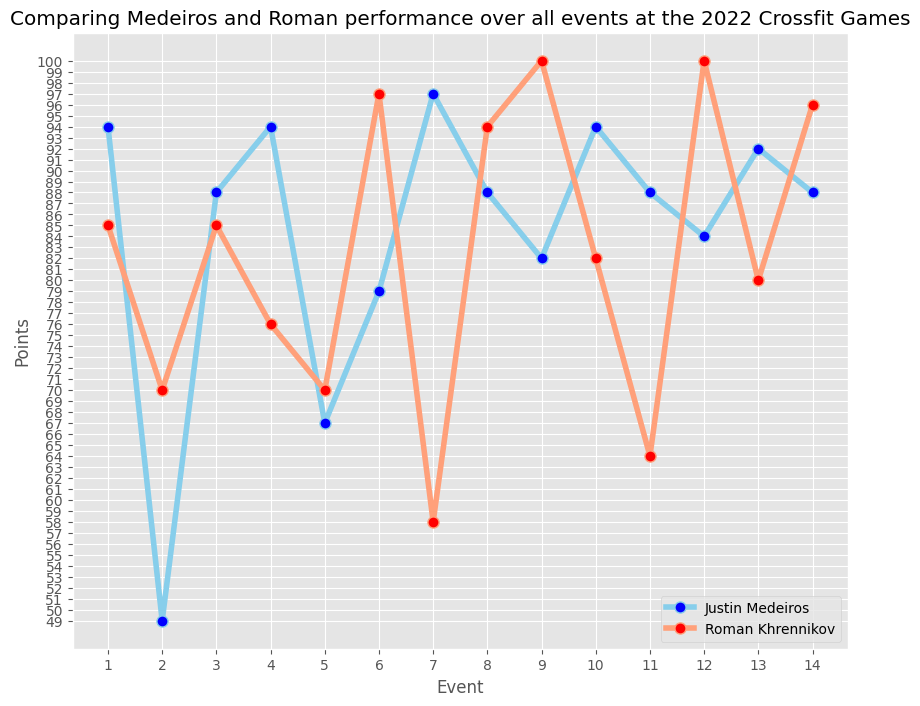

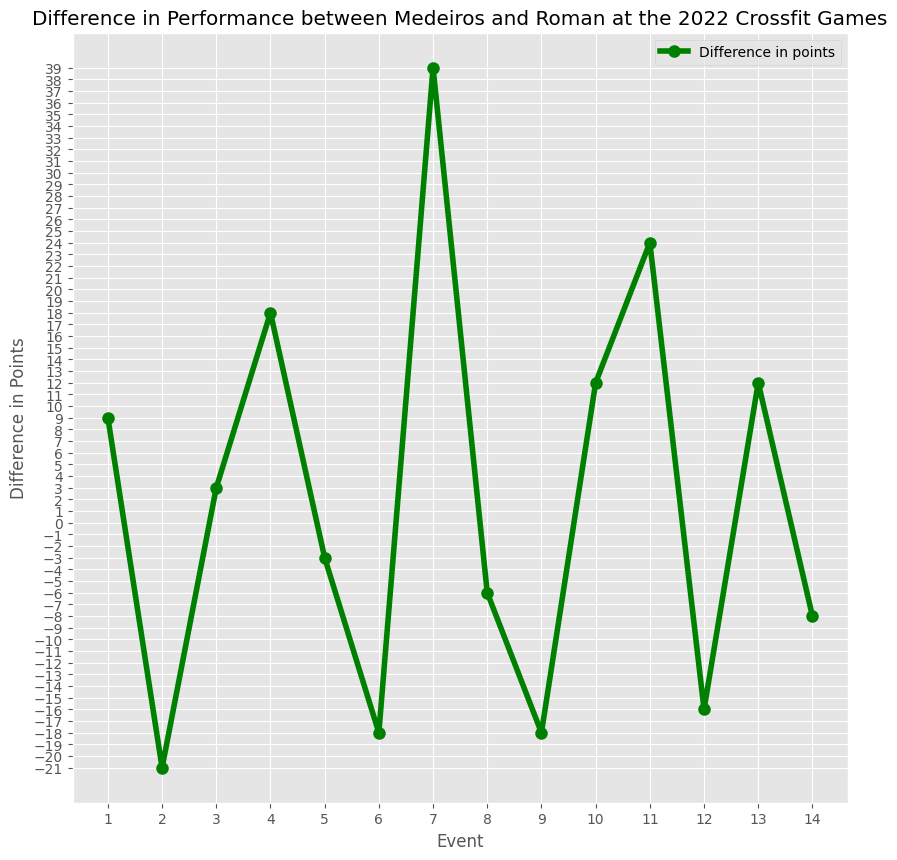

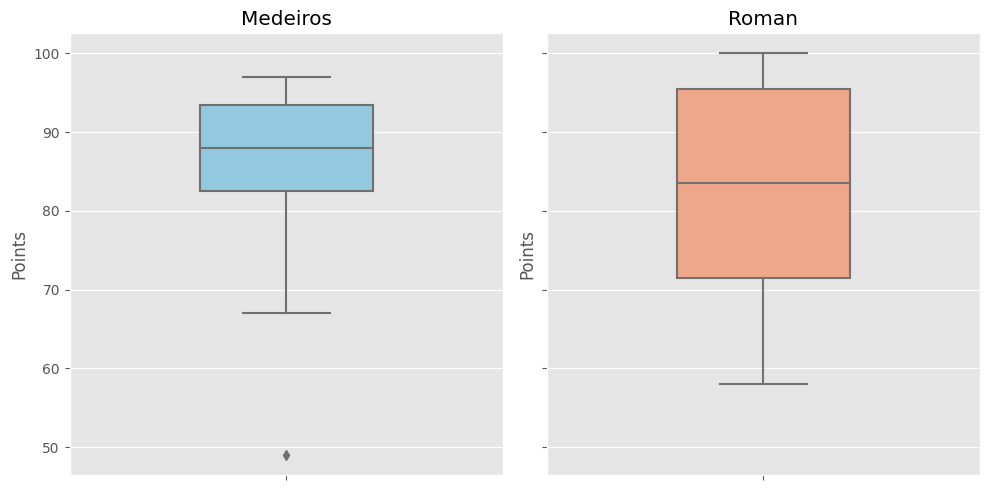

In [17]:
# check 2 top athlets during the event
mederos = df_cfgMalesEvents[df_cfgMalesEvents['competitorId'] == '811708'][(['event','points'])]
roman = df_cfgMalesEvents[df_cfgMalesEvents['competitorId'] == '975774'][(['event','points'])]



df_roman = roman.set_index('event', inplace=False)
df_mederos = mederos.set_index('event', inplace=False)

# Calculate the absolute difference between points for the two competitors
difference = pd.DataFrame({
    'difference': (df_mederos['points'] - df_roman['points'])
})
# abs_difference
difference.reset_index(inplace=True)


# Plot the lines for 'mederos' and 'roman'
plt.figure(figsize=(10, 8))
plt.plot('event', 'points', data=mederos, marker='o', label='Justin Medeiros',
         markerfacecolor='blue', markersize=8, color='skyblue', linewidth=4)
plt.plot('event', 'points', data=roman, marker='o', label='Roman Khrennikov',
         markerfacecolor='red', markersize=8, color='#FFA07A', linewidth=4)


plt.yticks(np.arange(min(min(mederos['points']), min(roman['points'])), max(max(mederos['points']), max(roman['points'])) + 1, 1))
plt.xticks(np.arange(min(mederos['event']), max(roman['event']) + 1, 1))
plt.legend(loc='lower right')
plt.title("Comparing Medeiros and Roman performance over all events at the 2022 Crossfit Games")
plt.xlabel('Event')
plt.ylabel('Points')
plt.show()

# Plot the line for the absolute difference in a separate figure
plt.figure(figsize=(10, 10))
plt.plot('event', 'difference', data=difference, marker='o', label='Difference in points',
         markerfacecolor='green', markersize=8, color='green', linewidth=4)

plt.yticks(np.arange(min(difference['difference']), max(difference['difference']) + 1, 1))
plt.xticks(np.arange(min(mederos['event']), max(mederos['event']) + 1, 1))
plt.legend()
plt.title("Difference in Performance between Medeiros and Roman at the 2022 Crossfit Games")
plt.xlabel('Event')
plt.ylabel('Difference in Points')
plt.show()

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)  # Use sharey=True to synchronize the Y-axis

mederos = df_cfgMalesEvents[df_cfgMalesEvents['competitorId'] == '811708'][(['event','points'])]
roman = df_cfgMalesEvents[df_cfgMalesEvents['competitorId'] == '975774'][(['event','points'])]

# Plot the first boxplot for "weightInKg" on the first subplot (ax1)
sns.boxplot(data=mederos, color="skyblue", width=0.4, y="points", ax=ax1)
ax1.set_title("Medeiros")

# Plot the second boxplot for "heightInCm" on the second subplot (ax2)
sns.boxplot(data=roman, color="#FFA07A", width=0.4, y="points", ax=ax2)
ax2.set_title("Roman")

# Set labels for the y axes
ax1.set_ylabel("Points")
ax2.set_ylabel("Points")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

We can see that Medeiros clearly gain point throught events: 7 (39 pts), 11 (24 pts) and 4 (18).
Roman's gains are event 2 (21 pts), 6 and 9 (both 18 pts). 

Let's check events closely.

Event 2: In each round, athletes will perform the run then complete as many jerks (shoulder-to-overheads) as possible in the time remaining. Shuttle to Overhead A will be the athlete’s total time to complete the 3 runs. 

Event 4: 3 rounds of races through pegboards, jump-ropes, pistols and handstand walks. Athletes will race through the 4 stations, with the fastest times moving on to the next round. 

Event 6: Athletes will begin with Pig flips at the Alliant Energy Center and then will run across town to the Capitol. There, they will perform farmers carries with the Jerry bags and Husafell carries down State Street, finishing on the steps of the Wisconsin State Capitol building.

Event 7: Athletes will complete 3 rounds of the triplet, then lunge with the axel bar to the finish line. Each round, the box jump object and height will change.

Event 9: 3 rounds for total time of: Sprint / 20 wall-ball shots / 6 dumbbell snatches. Rest 4 minutes between rounds.

Event 11: 1-rep-max sandbag-to-shoulder.

Biggest diffrence in Event 7, but Roman wasn't failed, it's just a tight competition as in Event 11 1 rep max. Roman did 320lbs and Justin 330lbs, but because of tiebreaks and close fields there are 24 pts + for Justin. But we can see at the boxplots that Justin is more stable however without event wins. But in modern CF you might not win any event and still be champion you just need not to failed. Single fail for Justin is 49 pts 18 place in running event all others are in 68-97 pts interval. Roman has no fails but his interval 58-100 pts. But still they are really close, no major weakness for both of them.

Garrard went good but in Event 8 he failed, 28th place with 26 pts, maybe he mentally loose after it. In this handstand push-up athletes will start by walking up the wall and onto an elevated block. They must then lower their head off the block to their deficit height without touching their head to the floor, then press back out to the top of their handstand. Here's the real fail, he struggled with HSPU and can't even finish in time. It's strange because often taller athlets has issues with HSPU and Ricky is 179 cm. Roman is 182 cm and he crushed that event.

Resuming: there are no clear strength/weakness in both Roman's and Justin's performance they both are very strong and stable athlets.

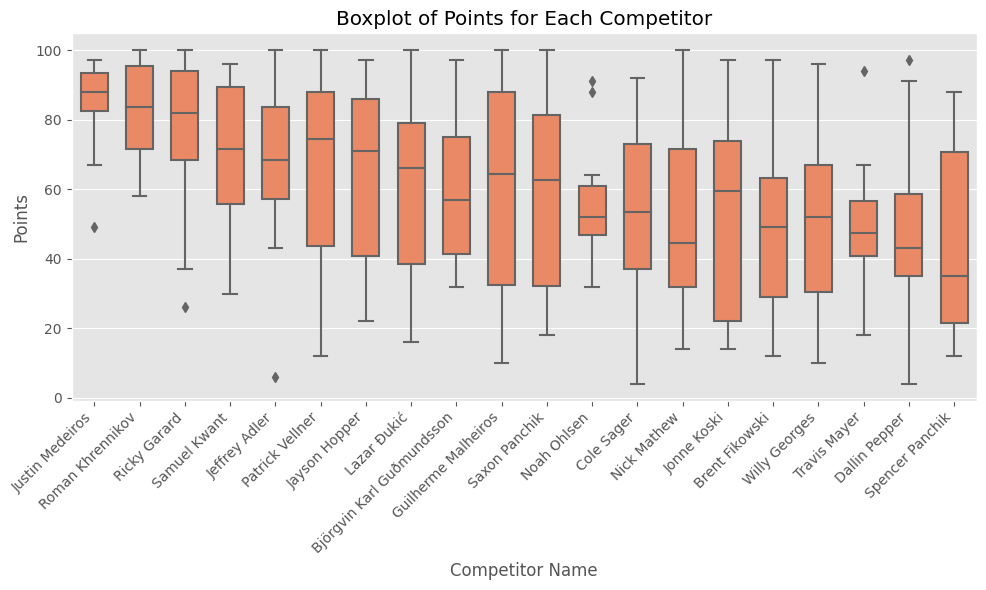

In [19]:
merged_df = pd.merge(df_cfgMalesEvents, df_cfgMales.head(20)[['competitorId', 'competitorName']], on='competitorId')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='competitorName', y='points', color='coral', width=0.6)

# Set labels and title
plt.xlabel('Competitor Name')
plt.ylabel('Points')
plt.title('Boxplot of Points for Each Competitor')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Here we can observ boxplots for top 20 athelets. As mentioned before less distribution is better. Ideal case is no outlier bottom, interval from 65+- - 100 pts. Justin is the most stable competitor with just one low result, Roman is decent but variance is higher. Ricky's variance is even hugher with one low result. Next interesting is Adler - He is fairy stable but his near 0 point result riuned the whole Games. After that variance for athlets is increasing and then Noah Olsen. He's pretty much as stable as Justin but stable at low points 45-62 with two outliers 90+ points. We can assume he is stable athlete but his skills/form can't compete for the win. Travis Mayer is similar but little more unstable. 